# How Images Activate Kernels

In [1]:
import os
import numpy as np
import torch
from torch.optim import SGD
from torchvision import models
import torch.nn as nn
from torch.autograd import Variable
import copy


import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import LogNorm
from astropy.io import fits
import matplotlib.pyplot as plt

from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from CNN_Networks import OU200_CNN, VIS_CNN, JYH_CNN, OU66_CNN

In [2]:
def Get200Images(name):
    images = np.zeros((1,4,200,200))
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_J/imageEUC_J-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    J = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_Y/imageEUC_Y-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    Y = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_H/imageEUC_H-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    H = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_VIS/imageEUC_VIS-'+str(name)+'.fits', ext=0)
    #image_data1 = resize(image_data1, (200,200))
    VIS = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    
    images[0,0] = J
    images[0,1] = Y
    images[0,2] = H
    images[0,3] = VIS
    #images = torch.from_numpy(images)
    
    return images

In [3]:
loadStates = {'J': 'OU_J_Weights.pt',
              'Y': 'OU_Y_Weights.pt',
              'H': 'OU_H_Weights.pt',
              'JYH': 'OU_JYH_Weights.pt',
              'VIS': 'OU_VIS_Weights.pt',
              'OU-66': '/Users/sunilmcesh/Documents/Github For Paper 1/LensFindery-McLensFinderFace/CNN Models/OU_66_Weights.pt',
              'OU-200': '/Users/sunilmcesh/Documents/Github For Paper 1/LensFindery-McLensFinderFace/CNN Models/OU_200_Weights.pt'}

In [4]:
model = OU200_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load(loadStates['OU-200'],map_location=torch.device('cpu')))

/Users/sunilmcesh/Documents/Github For Paper 1/CNN_Networks.py:510: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/Users/sunilmcesh/Documents/Github For Paper 1/CNN_Networks.py:516: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<All keys matched successfully>

## How activation is calculated
We go through each filter in each layer. We record the mean output for each layer. We use this to determine how much a filter is activated by an image. We also record the number when the filters progress to the next layer within the CNN.

In [5]:
name = 200001 
data = Get200Images(name)
#data = torch.rand([1,4,66,66])
data = torch.from_numpy(data)
tem = data.type(torch.FloatTensor)
e = []
X_line = []
X_tem = 0
for i in range(22):
    tem = model.layer[i](tem)
    #print(tem.shape)
    X_tem = tem.shape[1] + X_tem
    X_line.append(X_tem)
    for j in range(tem.shape[1]):
         # Conv2D
   # print(i)
    #print(tem.shape)
    #print(tem.mean().detach().numpy())
        e.append(tem[0,j].mean().detach().numpy())
        
tem = tem.view(tem.size()[0],-1)
fc_ranges = [350,350,2]
for i in range(3):
    tem = model.fc_layer[i](tem)
    #print(tem.shape)
    X_tem = tem.shape[1] + X_tem
    X_line.append(X_tem)
    for j in range(fc_ranges[i]):
        e.append(tem[0,j].mean().detach().numpy())
    
e = np.array(e)
X_line = np.array(X_line)

In [6]:
X_line

array([  50,  100,  150,  200,  240,  280,  320,  360,  390,  420,  450,
        480,  500,  520,  540,  560,  580,  600,  620,  640,  660,  680,
       1030, 1380, 1382])

In [7]:
e.shape

(1382,)

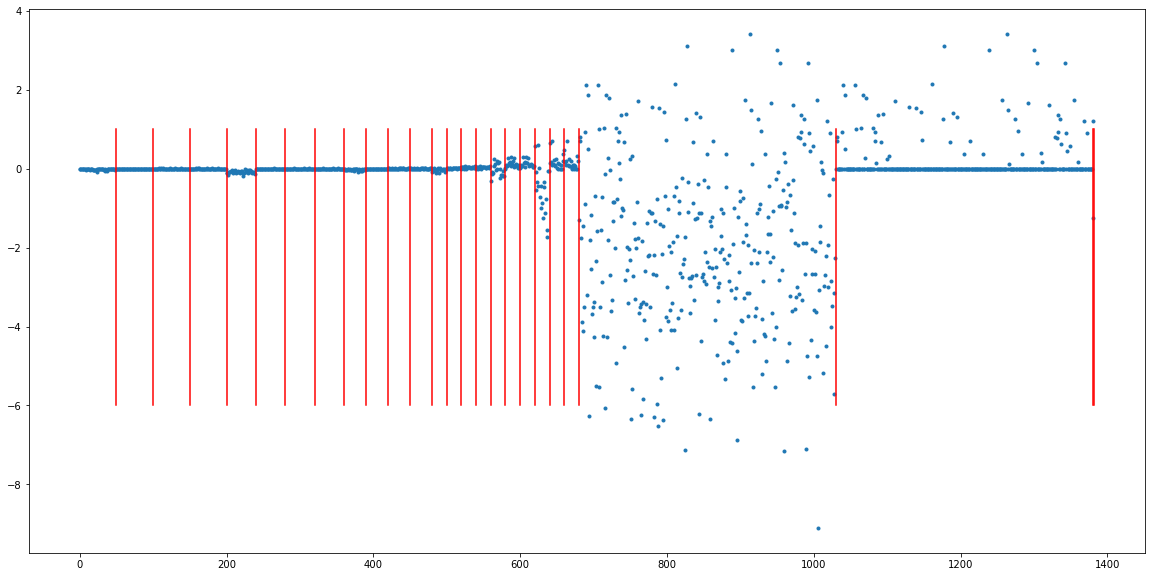

In [12]:
plt.figure(figsize=(20,10))
X = np.linspace(0,1382-1,1382)
plt.scatter(X, e,marker='.')
for i in range(X_line.shape[0]):
    plt.plot([X_line[i],X_line[i]],[-6,1],c='red')
plt.show()

In [8]:
def Get66Images(name):
    images = np.zeros((1,4,66,66))
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_J/imageEUC_J-'+str(name)+'.fits', ext=0)
    #image_data1 = resize(image_data1, (200,200))
    J = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_Y/imageEUC_Y-'+str(name)+'.fits', ext=0)
    #image_data1 = resize(image_data1, (200,200))
    Y = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_H/imageEUC_H-'+str(name)+'.fits', ext=0)
    #image_data1 = resize(image_data1, (200,200))
    H = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('/Volumes/Seagate Backup Plus Drive/Euclid 2 TrainData/EUC_VIS/imageEUC_VIS-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (66,66))
    VIS = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    
    images[0,0] = J
    images[0,1] = Y
    images[0,2] = H
    images[0,3] = VIS
    #images = torch.from_numpy(images)
    
    return images

In [9]:
model = OU66_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load(loadStates['OU-66'],map_location=torch.device('cpu')))

/Users/sunilmcesh/Documents/Github For Paper 1/CNN_Networks.py:446: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/Users/sunilmcesh/Documents/Github For Paper 1/CNN_Networks.py:452: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


RuntimeError: Error(s) in loading state_dict for OU66_CNN:
	Missing key(s) in state_dict: "VIS_layer.7.weight", "VIS_layer.7.bias", "VIS_layer.10.weight", "VIS_layer.10.bias", "VIS_layer.13.weight", "VIS_layer.13.bias", "VIS_layer.17.weight", "VIS_layer.17.bias", "VIS_layer.20.weight", "VIS_layer.20.bias", "VIS_layer.23.weight", "VIS_layer.23.bias", "VIS_layer.26.weight", "VIS_layer.26.bias". 
	Unexpected key(s) in state_dict: "JYH_layer.0.weight", "JYH_layer.0.bias", "JYH_layer.4.weight", "JYH_layer.4.bias", "JYH_layer.7.weight", "JYH_layer.7.bias", "JYH_layer.10.weight", "JYH_layer.10.bias", "JYH_layer.13.weight", "JYH_layer.13.bias", "JYH_layer.17.weight", "JYH_layer.17.bias", "JYH_layer.20.weight", "JYH_layer.20.bias", "JYH_layer.23.weight", "JYH_layer.23.bias", "JYH_layer.26.weight", "JYH_layer.26.bias", "JYH_fc_layer.0.weight", "JYH_fc_layer.0.bias", "VIS_fc_layer.0.weight", "VIS_fc_layer.0.bias", "VIS_layer.8.weight", "VIS_layer.8.bias", "VIS_layer.12.weight", "VIS_layer.12.bias", "VIS_layer.16.weight", "VIS_layer.16.bias", "VIS_layer.19.weight", "VIS_layer.19.bias", "fc_layer.4.weight", "fc_layer.4.bias", "fc_layer.6.weight", "fc_layer.6.bias", "fc_layer.8.weight", "fc_layer.8.bias", "fc_layer.10.weight", "fc_layer.10.bias". 
	size mismatch for VIS_layer.0.weight: copying a param with shape torch.Size([50, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([50, 4, 3, 3]).
	size mismatch for VIS_layer.4.weight: copying a param with shape torch.Size([40, 50, 5, 5]) from checkpoint, the shape in current model is torch.Size([50, 50, 3, 3]).
	size mismatch for VIS_layer.4.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for fc_layer.0.weight: copying a param with shape torch.Size([500, 850]) from checkpoint, the shape in current model is torch.Size([500, 120]).
	size mismatch for fc_layer.2.weight: copying a param with shape torch.Size([250, 500]) from checkpoint, the shape in current model is torch.Size([2, 500]).
	size mismatch for fc_layer.2.bias: copying a param with shape torch.Size([250]) from checkpoint, the shape in current model is torch.Size([2]).

In [10]:
model

OU66_CNN(
  (VIS_layer): Sequential(
    (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Conv2d(50, 40, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Dropout(p=0.2, inplace=False)
    (17): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): Dropout(p=0.2, inplace=False)
    (20): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (21): ReLU()
    (22): Dropout(p=0.2, 

In [11]:
torch.load(loadStates['OU-66'],map_location=torch.device('cpu'))

OrderedDict([('VIS_layer.0.weight',
              tensor([[[[ 2.9547e-01, -1.7026e-01,  2.6571e-01,  5.4105e-02,  1.1608e-01],
                        [-4.8590e-02,  3.1287e-01,  4.6895e-01, -2.9828e-01,  2.9628e-01],
                        [ 3.0184e-01, -3.2035e-01,  3.7623e-01, -2.6494e-01, -5.1393e-01],
                        [-2.3077e-02,  1.0717e-01, -1.8014e-01, -6.2700e-01,  5.3459e-04],
                        [-2.8322e-02, -1.8085e-01, -2.9446e-02, -7.3647e-02,  2.8460e-01]]],
              
              
                      [[[-8.2055e-02, -2.9803e-01, -2.2495e-01, -1.9187e-01,  3.0019e-01],
                        [-2.6155e-01, -2.8443e-01,  3.8533e-01, -1.7720e-01, -4.3842e-01],
                        [ 6.7290e-01, -2.3058e-01,  1.4655e-01, -1.8421e-01, -4.1464e-01],
                        [ 2.6168e-01,  3.4025e-01,  6.3715e-02, -1.4381e-01,  8.7851e-02],
                        [ 4.7942e-01, -7.2833e-02,  5.9679e-01, -5.0501e-01, -2.1882e-01]]],
              
     

In [ ]:
name = 200001 
data = Get66Images(name)
data = torch.from_numpy(data)
tem = data.type(torch.FloatTensor)
e = []
X_line = []
X_tem = 0
for i in range(30):
    tem = model.layer[i](tem)
    #print(tem.shape)
    X_tem = tem.shape[1] + X_tem
    X_line.append(X_tem)
    for j in range(tem.shape[1]):
         # Conv2D
   # print(i)
    #print(tem.shape)
    #print(tem.mean().detach().numpy())
        e.append(tem[0,j].mean().detach().numpy())
        
tem = tem.view(tem.size()[0],-1)
fc_ranges = [500,500,2]
for i in range(3):
    tem = model.fc_layer[i](tem)
    #print(tem.shape)
    X_tem = tem.shape[1] + X_tem
    X_line.append(X_tem)
    for j in range(fc_ranges[i]):
        e.append(tem[0,j].mean().detach().numpy())
    


e = np.array(e)
X_line = np.array(X_line)

In [ ]:
plt.figure(figsize=(20,10))
X = np.linspace(0,2292-1,2292)
plt.scatter(X, e,marker='.')
for i in range(X_line.shape[0]):
    plt.plot([X_line[i],X_line[i]],[-6,1],c='red')
plt.show()